# Melanoma Classification with a Random Model
Shall be used for comparison with other models

## 1. Set up

#### Set up for importing utilities

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

 #### Random State

In [2]:
from utilities import random_state
import numpy as np

random_state = random_state() 
seed = np.random.seed(random_state)

#### Export Config

In [3]:
export_results = True
on_cluster = False # there is some issue with h5py in the local env but it works on cluster so w/e
export_folder = f'export'

date_format = "%d%m%Y%H%M%S" # timestamp format in exported files
if export_results:
    import datetime
    import os
    if not os.path.exists(export_folder): 
      os.makedirs(export_folder)
      print("Created new directory %s" %export_folder)

#### img size config

In [4]:
img_pixel = 1 # can be low because the image is ignored anyways

#### Timer

Start the timer

In [5]:
import time
start = time.time()

## 2. Get data

#### Data Config

In [6]:
base_path = "data" 
downsampled_data = False
current_train_melanoma_percentage = 0.08

#### Get image paths
For developing models on the cluster the max_images parameter should be removed. Instead call the method get_all_img_paths(img_folder).

In [7]:
from utilities import get_all_img_paths, get_img_paths

img_folder_train = base_path + "/train" + ("_downsampled" if downsampled_data else "")
img_folder_test = base_path + "/test" + ("_downsampled" if downsampled_data else "")
max_images_train = 500
max_images_test = 50

img_paths_train = get_img_paths(img_folder_train, max_images_train) 
img_paths_test = get_img_paths(img_folder_test, max_images_test)

#### Load data
Loads the images specified in img_paths into a data frame. This includes resizing the images and flattening them into an array and may take a while.

In [8]:
from utilities import load_train_test

groundtruth_file_train = base_path + "/ISIC_2020_2019_train" + ("_downsampled" if downsampled_data else "") + ".csv" 
groundtruth_file_test = base_path + "/ISIC_2020_2019_test" + ("_downsampled" if downsampled_data else "") + ".csv"

# available options
options = ["sequential", # first load train, then load test
           "parallel_train_test", # load train and test parallel (load data within train and test sequential)
           "sequential_train_test_parallel_chunks", # load first train, then test, but load the data within the sets parallel
           "parallel_fusion" # run train and test parallel and parallely load data with train and test 
          ]

# chose an option
option = "parallel_fusion"

df_train, df_test = load_train_test(img_paths_train, groundtruth_file_train, 
                                    img_paths_test, groundtruth_file_test, 
                                    option, img_pixel);

Num images per thread 55
start loading train
start thread #0 for train
start loading test
start thread #1 for train
start thread #0 for test
start thread #2 for train
start thread #3 for train
start thread #4 for train
start thread #5 for train
start thread #6 for train
start thread #7 for train
start thread #8 for train
finished thread #0 for train
finished thread #1 for train
finished thread #2 for train
finished thread #3 for train
finished thread #0 for test
done loading test
finished thread #4 for train
finished thread #5 for train
finished thread #8 for train
finished thread #7 for train
finished thread #6 for train
done loading train


#### Split into target and predictors

In [9]:
from utilities import split_predictors_target

X_train, y_train = split_predictors_target(df_train) 
X_test, y_test = split_predictors_target(df_test) 

#### Clean up to save memory

In [10]:
del(df_train)
del(df_test)
del(img_paths_train)
del(img_paths_test)

## 3. Train model

#### Function to build the model

In [11]:
from sklearn.dummy import DummyClassifier

model = DummyClassifier(strategy='stratified', random_state=random_state)
model.fit(X_train, y_train)

DummyClassifier(random_state=42, strategy='stratified')

#### Timer
Stop the timer

In [12]:
stop = time.time()
print(f'It took {stop - start} s to load the data and train the model')

if export_results:
    f = open(f'{export_folder}/overall_time_{datetime.datetime.now().strftime(date_format)}.txt', 'w')
    f.write(f'Time it took : {stop - start} s')
    f.close()

It took 16.353508234024048 s to load the data and train the model


## 4. Test model

#### Predict test set

In [13]:
y_pred_continuous = model.predict(X_test)
y_pred_discrete = (model.predict(X_test) > 0.5).astype("int32")
y_pred = y_pred_discrete

#### Print classification report

In [14]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred, digits=4)
print(f'\nClassification_report=\n{report}')

if export_results:
    file = open(export_folder + "/classification_report_"+datetime.datetime.now().strftime(date_format)+".txt", 'w')
    file.write(report)
    file.close()


Classification_report=
              precision    recall  f1-score   support

           0     0.8605    0.8409    0.8506        44
           1     0.0000    0.0000    0.0000         6

    accuracy                         0.7400        50
   macro avg     0.4302    0.4205    0.4253        50
weighted avg     0.7572    0.7400    0.7485        50



#### Confusion Matrix

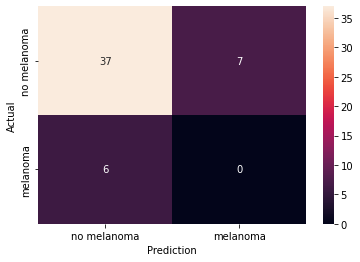

In [15]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

class_names = ["no melanoma", "melanoma"]

cf = confusion_matrix(y_test, y_pred)
plot = sns.heatmap(cf, annot= True, fmt=".0f",
           xticklabels = class_names,
           yticklabels = class_names)
plot.set(xlabel='Prediction', ylabel='Actual')

if export_results:
    plot.get_figure().savefig(export_folder + '/confusion_matrix_' + datetime.datetime.now().strftime(date_format) + ".png")